## Two-dimensional phase-field model for conserved order parameter (Cahn-Hilliard equation)
This python code was developed by Yamanaka research group of Tokyo University of Agriculture and Technology in August 2019.

## Problem
Let us consider an spinodal decomposition in a virtual A-B alloy. 
This notebook shows a two-dimensional phase-field simulation of the spinodal decomposition using Cahn-Hilliard equation. 

For details of the model, please see reference (J. W. Cahn and J. E. Hilliard, "Free Energy of a Non-Uniform System in Interfacial Energy" Journal of Chemical Physics, 28 (1958), pp. 258-267).

## Formulation
### 1. Order parameter
An order parameter $c$ is defined as the concentration of B atom. The unit of $c$ is defined as atomic fraction in this code.  

### 2. Total free energy
The total Gibbs free energy of the system is defined by
$$
G = \int_{V} \left( g_{chem}(c) + g_{grad}(\nabla c) \right) dV
$$
where $g_{chem}$ and $g_{grad}$ are the chemical free energy and the gradient energy densities, respectively. 
The chemical free energy density is formulated based on the regular solution approximation as:
$$
g_{chem} = RT\left[ c\ln c + (1-c)\ln(1-c)\right] + Lc(1-c)
$$
where $L$ is the atomic  interaction parameter. The gradient energy density is expressed by: 
$$
g_{grad} = \frac{a_{c}}{2} \left| \nabla c \right|^{2} 
$$
where $a_{c}$ is the gradient energy coefficient. In this model, $a_{c}$ is not related to any physical values. 

### 3. Time evolution equation 
The time evolution of the order parameter $c$ is given by assuming that the total free energy of the system $G$ decreases monotonically with time. For the conserved order parameter, the time evolution equation is derived from the Cahn-Hilliard equation given as: 
$$
\frac{\partial c}{\partial t} = \nabla \cdot \left( M_{c} \nabla \frac{\delta G}{\delta c} \right) =  \nabla \cdot \left( M_{c} \nabla \mu \right)
$$
where $\mu$ is the diffusion potential of B atom. According to the total Gibbs free energy, $\mu$ is expressed by: 
$$
\mu = \frac{\delta G}{\delta c} = RT\left[ \ln c - \ln (1-c) \right] + L(1-2c) - a_{c} \nabla^{2}c
$$
Here, remind that the functional derivative of $G$ is given by the Euler-Lagrange equation: 
$$
\frac{\delta G}{\delta c}=\frac{\partial g}{\partial c}-\nabla\cdot\frac{\partial g}{\partial (\nabla c)}
$$
$M$ is the diffusion mobility of B atom which is assumed to be given by: 
$$
M_{c} = \left[ \frac{D_{A}}{RT}c + \frac{D_{B}}{RT}(1-c)\right]c(1-c) = \frac{D_{A}}{RT}\left[ c + \frac{D_{B}}{D_{A}}(1-c)\right]c(1-c)
$$
Here, $D_{A}$ and $D_{B}$ are the diffusion coefficients of A and B atoms, respectively.  

Since the diffusion mobility $M_{c}$ depends on $c$, in two-dimensional space, the time evolution equation can be written as: 
$$
\frac{\partial c}{\partial t} =  \nabla \cdot \left( M_{c} \nabla \mu \right) = M_{c} \left(\frac{\partial^{2}\mu}{\partial x^{2}} +  \frac{\partial^{2}\mu}{\partial y^{2}}\right) + \frac{\partial M_{c}}{\partial c} \left( \frac{\partial c}{\partial x}\frac{\partial \mu}{\partial x} +  \frac{\partial c}{\partial y}\frac{\partial \mu}{\partial y} \right)
$$
where the derivative of $M_{c}$ with respect to $c$ is given by: 
$$
\frac{\partial M_{c}}{\partial c} = \frac{D_{A}}{RT}\left[ \left(1-\frac{D_{B}}{D_{A}}\right)c(1-c) + \left(c+ \frac{D_{B}}{D_{A}}(1-c)\right)(1-2c) \right]
$$

### import libraries

In [1]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt

### set parameters and physical values

In [2]:
nx = 32 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
dx, dy = 2.0e-9, 2.0e-9 # spacing of computational grids [m]
c0 = 0.5 # average composition of B atom [atomic fraction]
R = 8.314 # gas constant
temp = 673 # temperature [K]
nsteps = 6000# total number of time-steps

### set and calculate parameters ($L$, $a_{c}$, $D_{A}$, $D_{B}$)

In [3]:
La = 20000.-9.*temp # Atom intaraction constant [J/mol]
ac = 3.0e-14 # gradient coefficient [Jm2/mol]
Da = 1.0e-04*np.exp(-300000.0/R/temp) # diffusion coefficient of A atom [m2/s]
Db = 2.0e-05*np.exp(-300000.0/R/temp) # diffusion coefficient of B atom [m2/s]
dt = (dx*dx/Da)*0.1 # time increment [s]

### check chemical free energy density curve
The chemical free energy and the average chemical composition are shown in a graph. 

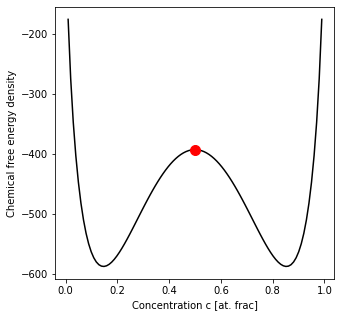

In [4]:
fig = plt.figure(figsize=(5,5))
cc = np.linspace(0.01, 0.99, 100);
plt.plot(cc, R*temp*(cc*np.log(cc)+(1-cc)*np.log(1-cc))+La*cc*(1-cc),color='black')
plt.plot(c0, R*temp*(c0*np.log(c0)+(1-c0)*np.log(1-c0))+La*c0*(1-c0),color='r',marker='o',markersize=10)
plt.xlabel('Concentration c [at. frac]')
plt.ylabel('Chemical free energy density')
plt.show()

### declair arrays for the order parameters $c$ at time $t$ and $t+\Delta t$

In [5]:
c = np.zeros((nx,ny)) # order parameter c at time t
c_new = np.zeros((nx,ny)) # order parameter c at time t+dt

### define the function which updates the order parameter c
The Cahn-Hilliard equation is discretized by simple finite difference method in this program. 
The 1st-order Euler method is used for time-integration. The 2nd-order central finite difference method is used for spatial derivatives. The discretized time evolution equation is given as: 
$$
c^{t+\Delta t}_{i,j} = c^{t}_{i,j} + M_{c} A_{i,j} + B_{i,j}C_{i,j}
$$
where $c^{t}_{i,j}$ denotes the concentration of B atom at time $t$ and the computational grid point $(i,j)$. 

The discretized expressions of each term are given by:
$$
M_{c} = \frac{D_{A}}{RT}\left[ c^{t}_{i,j}  + \frac{D_{B}}{D_{A}}(1-c^{t}_{i,j} )\right]c^{t}_{i,j} (1-c^{t}_{i,j})
$$

$$
\frac{\partial^{2}\mu}{\partial x^{2}} +  \frac{\partial^{2}\mu}{\partial y^{2}} \simeq A_{i,j} = \frac{\mu^{t}_{i+1,j} -2\mu^{t}_{i,j}+\mu^{t}_{i-1,j}}{(\Delta x)^{2}} + \frac{\mu^{t}_{i,j+1} -2\mu^{t}_{i,j}+\mu^{t}_{i,j-1}}{(\Delta y)^{2}}
$$

$$
\frac{\partial M_{c}}{\partial c} \simeq B_{i,j} = \frac{D_{A}}{RT}\left[ \left(1-\frac{D_{B}}{D_{A}}\right)c^{t}_{i,j}(1-c^{t}_{i,j}) + \left(c^{t}_{i,j}+ \frac{D_{B}}{D_{A}}(1-c^{t}_{i,j})\right)(1-2c^{t}_{i,j}) \right]
$$

$$
\frac{\partial c}{\partial x}\frac{\partial \mu}{\partial x} +  \frac{\partial c}{\partial y}\frac{\partial \mu}{\partial y} \simeq
C_{i,j} = \frac{(c^{t}_{i+1,j}-c^{t}_{i-1,j})(\mu^{t}_{i+1,j}-\mu^{t}_{i-1,j})}{4(\Delta x)^{2}} + \frac{(c^{t}_{i,j+1}-c^{t}_{i,j-1})(\mu^{t}_{i,j+1}-\mu^{t}_{i,j-1})}{4(\Delta y)^{2}} 
$$
where $\mu^{t}_{i,j}$ is the diffusion potential of B atom at time $t$ and the computational grid point $(i,j)$, which is given by:
$$
\mu^{t}_{i,j} =\mu^{t,chem}_{i,j} + \mu^{t,grad}_{i,j} = RT\left[ \ln c^{t}_{i,j} - \ln (1-c^{t}_{i,j}) \right] + L(1-2c^{t}_{i,j}) - a_{c} \left[ \frac{c^{t}_{i+1,j} -2c^{t}_{i,j}+c^{t}_{i-1,j}}{(\Delta x)^{2}} + \frac{c^{t}_{i,j+1} -2c^{t}_{i,j}+c^{t}_{i,j-1}}{(\Delta y)^{2}} \right]
$$
where $\mu^{t,chem}_{i,j}$ and $\mu^{t,grad}_{i,j}$ are the chemical and gradient terms of the diffusion potential. 

In [6]:
def update_orderparameter(c,c_new):
    for j in range(ny):
        for i in range(nx):
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_chem_c = R*temp*(np.log(cc)-np.log(1.0-cc)) + La*(1.0-2.0*cc) # chemical term of the diffusion potential
            mu_chem_w = R*temp*(np.log(cw)-np.log(1.0-cw)) + La*(1.0-2.0*cw) 
            mu_chem_e = R*temp*(np.log(ce)-np.log(1.0-ce)) + La*(1.0-2.0*ce) 
            mu_chem_n = R*temp*(np.log(cn)-np.log(1.0-cn)) + La*(1.0-2.0*cn)  
            mu_chem_s = R*temp*(np.log(cs)-np.log(1.0-cs)) + La*(1.0-2.0*cs) 

            mu_grad_c = -ac*( (ce -2.0*cc +cw )/dx/dx + (cn  -2.0*cc +cs )/dy/dy ) # gradient term of the diffusion potential
            mu_grad_w = -ac*( (cc -2.0*cw +cww)/dx/dx + (cnw -2.0*cw +csw)/dy/dy )
            mu_grad_e = -ac*( (cee-2.0*ce +cc )/dx/dx + (cne -2.0*ce +cse)/dy/dy )  
            mu_grad_n = -ac*( (cne-2.0*cn +cnw)/dx/dx + (cnn -2.0*cn +cc )/dy/dy ) 
            mu_grad_s = -ac*( (cse-2.0*cs +csw)/dx/dx + (cc  -2.0*cs +css)/dy/dy )              
            
            mu_c = mu_chem_c + mu_grad_c # total diffusion potental
            mu_w = mu_chem_w + mu_grad_w 
            mu_e = mu_chem_e + mu_grad_e 
            mu_n = mu_chem_n + mu_grad_n 
            mu_s = mu_chem_s + mu_grad_s 
    
            nabla_mu = (mu_w -2.0*mu_c + mu_e)/dx/dx + (mu_n -2.0*mu_c + mu_s)/dy/dy    
            dc2dx2 = ((ce-cw)*(mu_e-mu_w))/(4.0*dx*dx)
            dc2dy2 = ((cn-cs)*(mu_n-mu_s))/(4.0*dy*dy) 
            
            DbDa = Db/Da
            mob = (Da/R/temp)*(cc+DbDa*(1.0-cc))*cc*(1.0-cc) 
            dmdc = (Da/R/temp)*((1.0-DbDa)*cc*(1.0-cc)+(cc+DbDa*(1.0-cc))*(1.0-2.0*cc)) 
        
            dcdt = mob*nabla_mu + dmdc*(dc2dx2 + dc2dy2) # right-hand side of Cahn-Hilliard equation
            c_new[i,j] = c[i,j] + dcdt *dt # update order parameter c 

### Set initial distribution of order paraemter (concentration of B atom)
The initial distribution of $c$ is determined as $c_{0}$ + uniform random number. 

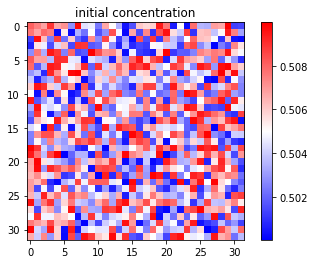

In [7]:
c = np.zeros((nx,ny)) # zero-clear
c_new = np.zeros((nx,ny)) # zero clear

c = c0 + np.random.rand(nx, ny)*0.01

plt.imshow(c, cmap='bwr')
plt.title('initial concentration')
plt.colorbar()
plt.show()

### solve Cahn-Hilliard equation (calculate time evolution of concentration-field during the spinodal decomposition)

nstep =  600
Maximum concentration =  0.511475385611644
Minimum concentration =  0.4982076807959412


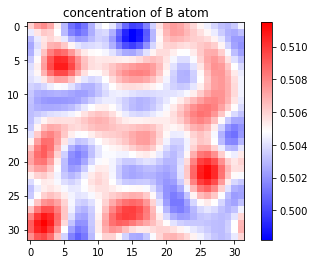

nstep =  1200
Maximum concentration =  0.5308126662174383
Minimum concentration =  0.4815332533348282


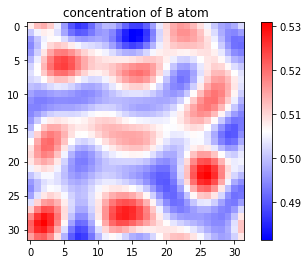

nstep =  1800
Maximum concentration =  0.6157578032830883
Minimum concentration =  0.4158051061810225


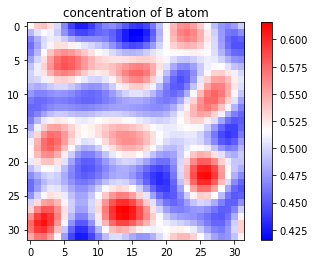

nstep =  2400
Maximum concentration =  0.7937321400270263
Minimum concentration =  0.26761699475352585


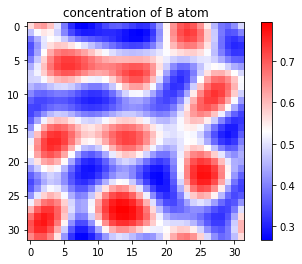

nstep =  3000
Maximum concentration =  0.8443128552618852
Minimum concentration =  0.18134022315819176


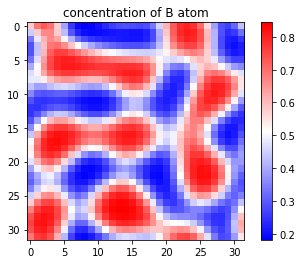

nstep =  3600
Maximum concentration =  0.8460110279815508
Minimum concentration =  0.17096036404335258


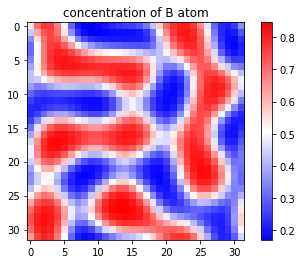

nstep =  4200
Maximum concentration =  0.8433815815439933
Minimum concentration =  0.1673002145481436


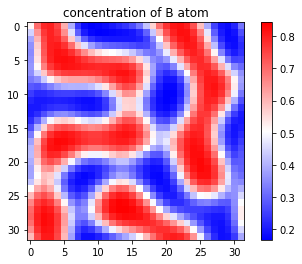

nstep =  4800
Maximum concentration =  0.8434979478572038
Minimum concentration =  0.16074284231935004


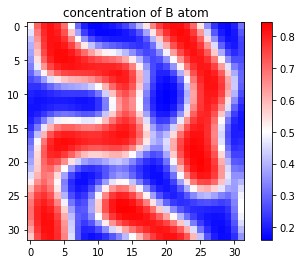

nstep =  5400
Maximum concentration =  0.8441221434019501
Minimum concentration =  0.158450275328618


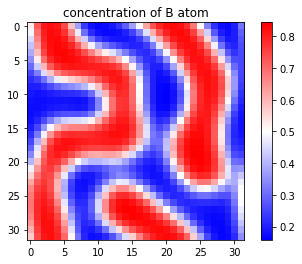

nstep =  6000
Maximum concentration =  0.8468658352098742
Minimum concentration =  0.16100124096064614


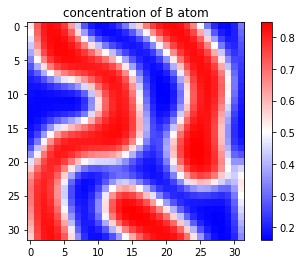

In [8]:
for nstep in range(1,nsteps+1):
    update_orderparameter(c,c_new)
    c[:,:] = c_new[:,:] # swap c at time t and c at time t+dt
    
    if nstep % 600 == 0:
        print('nstep = ', nstep)
        print('Maximum concentration = ', np.max(c))
        print('Minimum concentration = ', np.min(c))
        plt.imshow(c, cmap='bwr')
        plt.title('concentration of B atom')
        plt.colorbar()
        plt.show() 